In [1]:
import tabular_methods.dynamic_programming as dp
import tabular_methods.montecarlo as mc
import tabular_methods.temporal_difference as td

import utils.maze

Creating the Maze:



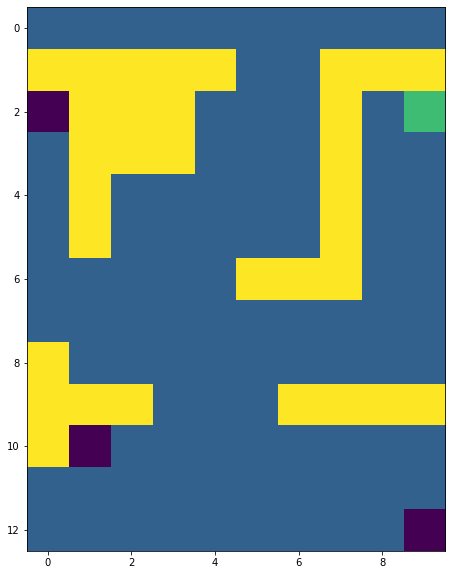

epochs:  46
Results of the DP agent:



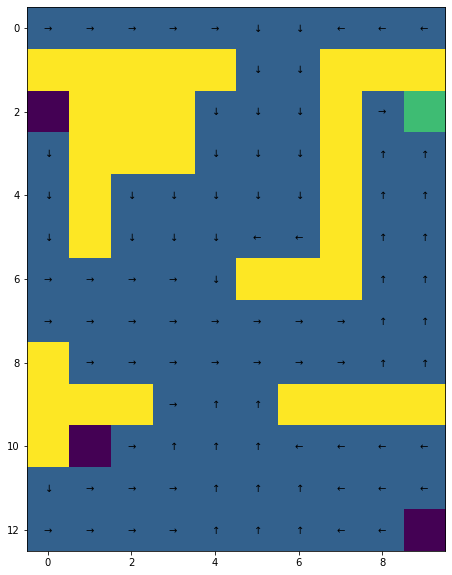

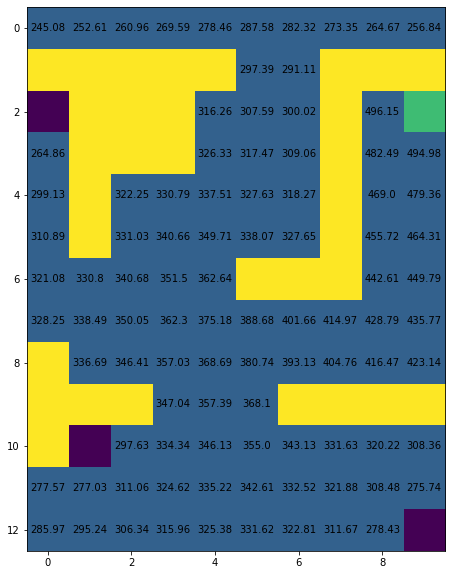

Solving episode 999, of length 755
Results of the MC agent:



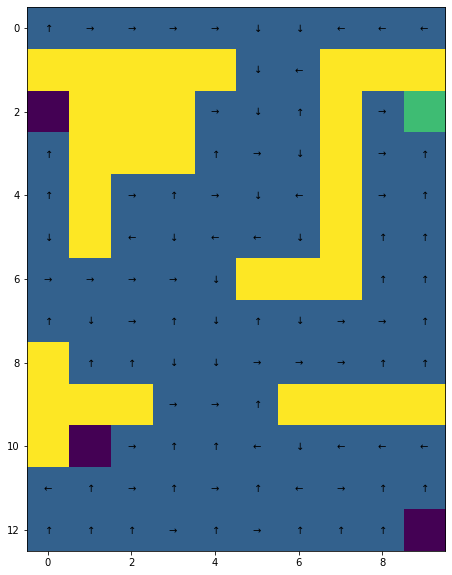

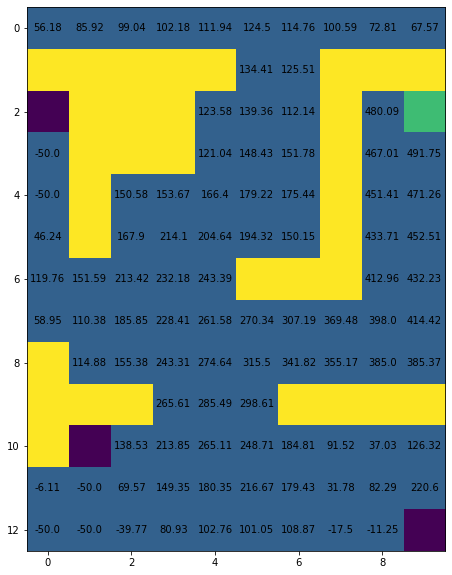

Solving episode 999
Results of the TD agent:



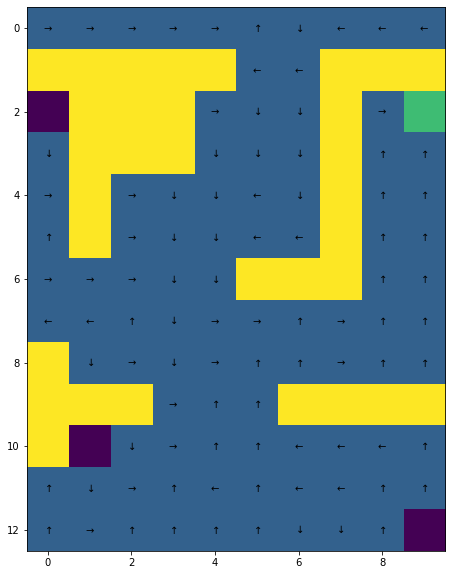

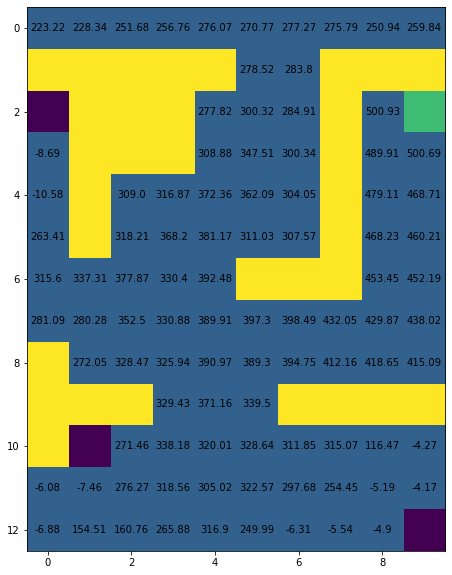

In [4]:
# Defining the environment

print("Creating the Maze:\n")
maze = utils.maze.Maze()


# Dynamic programming

dp_agent = dp.DP_agent()
dp_policy, dp_value = dp_agent.solve(maze)

print("Results of the DP agent:\n")
maze.get_graphics().draw_policy(dp_policy, "out/dp/")
maze.get_graphics().draw_value(dp_value, "out/dp/")

# Monte-Carlo learning

mc_agent = mc.MC_agent()
mc_policy, mc_values, total_rewards = mc_agent.solve(maze)

print("Results of the MC agent:\n")
maze.get_graphics().draw_policy(mc_policy, "out/mc/")
maze.get_graphics().draw_value(mc_values[-1], "out/mc/")


# Temporal-Difference learning

td_agent = td.TD_agent()
td_policy, td_values, total_rewards = td_agent.solve(maze)

print("Results of the TD agent:\n")
maze.get_graphics().draw_policy(td_policy, "out/td/")
maze.get_graphics().draw_value(td_values[-1], "out/td/")